# For the main parameter space figures

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np
from scipy import interpolate

from matplotlib import rc, rcParams
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import pathos.multiprocessing as mp
from pathos.multiprocessing import ProcessingPool as Pool

from functools import partial

from particle import *
from particle import literals as lp

from HNL_MC import *
from HNL_MC.plot_style import *
from HNL_MC.const import *

from Nlimits import *
from Nlimits.constraint_dict import *
from Nlimits.plotter import *

from utils_limits import *

### Minimal version

In [40]:
# grid of mix vs mass
gridx = 100
gridy = 40

M4 = np.linspace(0.02,(m_neutral_kaon - m_charged_pion - m_mu), gridx)
USQR = np.logspace(-9,-2, gridy) 
X,Y = np.meshgrid(M4,USQR)
m4_grid, usqr_grid = X.flatten(), Y.flatten()

# define non-scan parameters


tot_cores = mp.cpu_count()
pool = Pool(tot_cores)
############


dipoles = [0,0,0]
GX = 0.0
get_event_partial = partial(hnl_tools.get_event_rate, flavor_struct=[0.0,1.0,0.0], dipoles=dipoles, GX=GX, exp_setup = exp.ND280_FHC)
event_rate_weak = pool.map(get_event_partial, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

get_lifetime_partial = partial(hnl_tools.get_lifetime, flavor_struct=[0.0,1.0,0.0], dipoles=dipoles, GX=GX)
lifetime_weak = pool.map(get_lifetime_partial, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

############
pool.terminate()
pool.restart()

<multiprocess.pool.Pool state=RUN pool_size=8>

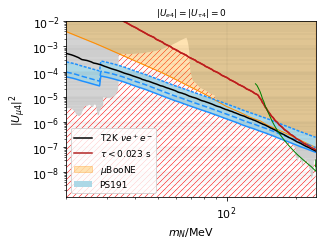

In [61]:
######
fig, ax = std_fig()

# HNL mass span
x = np.logspace(np.log10(20),np.log10((m_neutral_kaon - m_charged_pion - m_mu)*1e3), 1000, endpoint=True)

###################################
# plot all existing constraints

list_of_bounds=umu4.get_individual_bounds(muon_bounds, m4min=0.01, m4max=0.2)
# _ = plot_bound(ax, list_of_bounds['SIN_87'], units=1e3)
_ = plot_bound(ax, list_of_bounds['PSI_87'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['PS191'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['KEK'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['NA62_21'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['PIENU_19_lowT'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['PIENU_19_highT'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['deGouvea_lowmass'], units=1e3, lw=0.0)

this_file = 'digitized/muboone_kelly_machado/PS_eff_avg.dat'
m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
f = interpolate.interp1d(np.log10(m4), np.log10(Umu4sq), kind='linear', bounds_error=False, fill_value='extrapolate', assume_sorted=False)    
ax.fill_between(x, 10**f(np.log10(x)), np.ones(len(f(x))), fc='orange', ec='darkorange', alpha=0.3, label=r'$\mu$BooNE')
ax.plot(x, 10**f(np.log10(x)), c='darkorange', ls='-', lw=1)

# this_file = 'digitized/muboone_kelly_machado/PS_eff_scalar.dat'
# m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
# f = interpolate.interp1d(m4, Umu4sq, kind='linear', bounds_error=False, fill_value=None, assume_sorted=False)    
# ax.plot(x, f(x), c='grey', ls='--', label='Kelly \& Machado 2')


############################################
# PS191 rescaled
N_observed = 30 # before handscan
no_bkg, all_bkg = get_PS191_limit(x*1e-3, nevent_for_new_limit = np.sqrt(N_observed))
_, all_sig = get_PS191_limit(x*1e-3, nevent_for_new_limit = N_observed+np.sqrt(N_observed))

ax.fill_between(x, no_bkg, all_bkg, facecolor='lightblue', lw=0.0, label=r'PS191')
ax.fill_between(x, all_bkg, all_sig, facecolor='lightblue', lw=0.0)
ax.plot(x, no_bkg, color='dodgerblue', ls='-')
ax.plot(x, all_bkg, color='dodgerblue', ls='--')
ax.plot(x, all_sig, color='dodgerblue', dashes=(2,1))


############################################
# our T2K bound -- Weak Interaction only
Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid*1e3, y=usqr_grid , z=event_rate_weak, logx=True, logy=True)
level_0 = contour(Xi, Yi, Zi, levels = [2.3], colors=['black'], linewidths=[0]) #NEW CONSTRAINT
bound = level_0.collections[0].get_paths()[0].vertices  #grab the coords of the bound
ax.plot(bound[:,0],bound[:,1], c='black', label=r'T2K $\nu e^+e^-$', lw=1.5)


############################################
# BBN -- tau = 0.023 s
matplotlib.rcParams['hatch.color'] = 'red'  # previous pdf hatch linewidth
matplotlib.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid*1e3, y=usqr_grid , z=lifetime_weak, logx=True, logy=True)
level_1 = contour(Xi, Yi, Zi, levels = [0.023], colors=['red'], linestyles=['-']) #NEW CONSTRAINT
_ = contourf(Xi, Yi, Zi, levels = [0.023,np.inf], colors=['white'], alpha=1, hatches=['////'], linestyles=['-'], zorder=-1) #NEW CONSTRAINT
bound = level_1.collections[0].get_paths()[0].vertices  #grab the coords of the bound
ax.plot(bound[:,0],bound[:,1], c='firebrick', label=r'$\tau < 0.023$ s', lw=1.5)

# test against boyarki's
mbound,ubound = np.genfromtxt('digitized/Boyarsky_et_al/BBN_Umu4_lower_bound.dat',unpack=True)
plt.plot(mbound*1e3,ubound, c='green',lw=1)

# T2K bound
# ax.plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
#                                                           channels=np.arange(10), 
#                                                           modes=modes_dirac, 
#                                                           mode_weights=weights_modes_dirac)),
#             label=r'T2K', c='purple')


####
# labels
ax.set_title(r"$|U_{e4}| = |U_{\tau 4}| = 0$",fontsize=9)
ax.legend(loc='lower left', frameon=True, ncol=1, fontsize=9)

ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(1e-9,1e-2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$|U_{\mu 4}|^2$")
ax.set_xlabel(r"$m_{N}$/MeV")
ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,1e-2])
# ax.set_xticks(np.array([0.02, 0.04, 0.06, 0.08, 0.1, m_neutral_pion-m_mu, m_neutral_kaon-m_mu-m_neutral_pion])*1e3)
# ax.set_xticklabels(np.array([0.02, 0.04, 0.06, 0.08, 0.1, r'$m_\pi-m_\mu$', r'$m_K - (m_\mu+m_\pi)$']), rotation = -30)
ax.grid(axis='y', which='both',dashes=(6,1),alpha=0.5,c='black',lw=0.1)
ax.grid(axis='x', which='major',dashes=(6,1),alpha=0.5,c='black',lw=0.1)
fig.savefig('plots/weak_decays.pdf')
fig.savefig('plots/weak_decays.png', dpi=400)

# Dipole case 

In [19]:
# grid of mix vs mass
gridx = 100
gridy = 40

M4 = np.linspace(0.02,(m_neutral_kaon - m_charged_pion - m_mu), gridx)
USQR = np.logspace(-14,-4, gridy) 
X,Y = np.meshgrid(M4,USQR)
m4_grid, usqr_grid = X.flatten(), Y.flatten()

tot_cores = mp.cpu_count()
pool = Pool(tot_cores)
############

dipoles = [0,5e-7,0]
GX = 0.0
get_event_partial = partial(hnl_tools.get_event_rate, flavor_struct=[0.0,1.0,0.0], dipoles=dipoles, GX=GX, exp_setup = exp.ND280_FHC)
event_rate_dipole = pool.map(get_event_partial, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))
get_lifetime_partial = partial(hnl_tools.get_lifetime, flavor_struct=[0.0,1.0,0.0], dipoles=dipoles, GX=GX)
lifetime_dipole = pool.map(get_lifetime_partial, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

############
pool.terminate()
pool.restart()

<multiprocess.pool.Pool state=RUN pool_size=8>

<ipython-input-38-5877aba5685c>:67: UserWarning: No contour levels were found within the data range.
  level_1 = contour(Xi, Yi, Zi, levels = [0.023], colors=['red'], linestyles=['--']) #NEW CONSTRAINT


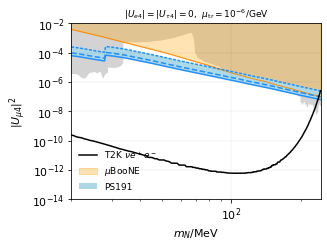

In [38]:
# grid of mix vs mass
gridx = 100
gridy = 40

M4 = np.linspace(0.02,(m_neutral_kaon - m_charged_pion - m_mu), gridx)
USQR = np.logspace(-14,-4, gridy) 
X,Y = np.meshgrid(M4,USQR)
m4_grid, usqr_grid = X.flatten(), Y.flatten()



######
fig, ax = std_fig()

# HNL mass span
x = np.logspace(np.log10(20),np.log10((m_neutral_kaon - m_charged_pion - m_mu)*1e3), 1000, endpoint=True)

###################################
# plot all existing constraints

list_of_bounds=umu4.get_individual_bounds(muon_bounds, m4min=0.01, m4max=0.2)
# _ = plot_bound(ax, list_of_bounds['SIN_87'], units=1e3)
_ = plot_bound(ax, list_of_bounds['PSI_87'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['PS191'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['KEK'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['NA62_21'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['PIENU_19_lowT'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['PIENU_19_highT'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['deGouvea_lowmass'], units=1e3, lw=0.0)

this_file = 'digitized/muboone_kelly_machado/PS_eff_avg.dat'
m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
f = interpolate.interp1d(np.log10(m4), np.log10(Umu4sq), kind='linear', bounds_error=False, fill_value='extrapolate', assume_sorted=False)    
ax.fill_between(x, 10**f(np.log10(x)), np.ones(len(f(x))), fc='orange', ec='darkorange', alpha=0.3, label=r'$\mu$BooNE')
ax.plot(x, 10**f(np.log10(x)), c='darkorange', ls='-', lw=1)

# this_file = 'digitized/muboone_kelly_machado/PS_eff_scalar.dat'
# m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
# f = interpolate.interp1d(m4, Umu4sq, kind='linear', bounds_error=False, fill_value=None, assume_sorted=False)    
# ax.plot(x, f(x), c='grey', ls='--', label='Kelly \& Machado 2')


############################################
# PS191 rescaled
N_observed = 30 # before handscan
no_bkg, all_bkg = get_PS191_limit(x*1e-3, nevent_for_new_limit = np.sqrt(N_observed))
_, all_sig = get_PS191_limit(x*1e-3, nevent_for_new_limit = N_observed+np.sqrt(N_observed))

ax.fill_between(x, no_bkg, all_bkg, facecolor='lightblue', lw=0.0, label=r'PS191')
ax.fill_between(x, all_bkg, all_sig, facecolor='lightblue', lw=0.0)
ax.plot(x, no_bkg, color='dodgerblue', ls='-')
ax.plot(x, all_bkg, color='dodgerblue', ls='--')
ax.plot(x, all_sig, color='dodgerblue', dashes=(2,1))


############################################
# our T2K bound -- Weak Interaction only
Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid*1e3, y=usqr_grid , z=event_rate_dipole, logx=True, logy=True)
level_0 = contour(Xi, Yi, Zi, levels = [2.3], colors=['black'], linewidths=[0]) #NEW CONSTRAINT
bound = level_0.collections[0].get_paths()[0].vertices  #grab the coords of the bound
ax.plot(bound[:,0],bound[:,1], c='black', label=r'T2K $\nu e^+e^-$', lw=1.5)


############################################
# BBN -- tau = 0.023 s
Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid*1e3, y=usqr_grid , z=lifetime_dipole, logx=True, logy=True)
level_1 = contour(Xi, Yi, Zi, levels = [0.023], colors=['red'], linestyles=['--']) #NEW CONSTRAINT
# level_1 = contour(Xi, Yi, Zi, levels = [280e2/c_LIGHT/20], colors=['red'], linestyles=['--']) #NEW CONSTRAINT
# level_1 = contour(Xi, Yi, Zi, levels = [280e2/c_LIGHT/80], colors=['red'], linestyles=['--']) #NEW CONSTRAINT
# test against boyarki's
# mbound,ubound = np.genfromtxt('digitized/Boyarsky_et_al/BBN_Umu4_lower_bound.dat',unpack=True)
# plt.plot(mbound*1e3,ubound, c='green',lw=1)

# T2K bound
# ax.plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
#                                                           channels=np.arange(10), 
#                                                           modes=modes_dirac, 
#                                                           mode_weights=weights_modes_dirac)),
#             label=r'T2K', c='purple')


####
# labels
ax.set_title(r"$|U_{e4}| = |U_{\tau 4}| = 0$,  $\mu_{\rm tr} = 10^{-6}/$GeV",fontsize=9)
ax.legend(loc='lower left', frameon=False, ncol=1, fontsize=9)

ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(1e-14,1e-2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$|U_{\mu 4}|^2$")
ax.set_xlabel(r"$m_{N}$/MeV")
# ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,1e-2])
# ax.set_xticks(np.array([0.02, 0.04, 0.06, 0.08, 0.1, m_neutral_pion-m_mu, m_neutral_kaon-m_mu-m_neutral_pion])*1e3)
# ax.set_xticklabels(np.array([0.02, 0.04, 0.06, 0.08, 0.1, r'$m_\pi-m_\mu$', r'$m_K - (m_\mu+m_\pi)$']), rotation = -30)
ax.grid(axis='y', which='both',dashes=(6,1),alpha=0.5,c='black',lw=0.1)
ax.grid(axis='x', which='major',dashes=(6,1),alpha=0.5,c='black',lw=0.1)
fig.savefig('plots/dipole_decays.pdf')
fig.savefig('plots/dipole_decays.png', dpi=400)

# Dark Z' case

In [34]:
# grid of mix vs mass
gridx = 100
gridy = 100

M4 = np.linspace(0.02,(m_neutral_kaon - m_charged_pion - m_mu), gridx)
USQR = np.logspace(-11,0, gridy) 
X,Y = np.meshgrid(M4,USQR)
m4_grid, usqr_grid = X.flatten(), Y.flatten()

tot_cores = mp.cpu_count()
pool = Pool(tot_cores)
############

dipoles = [0,0,0]
GX = Gf*50
get_event_partial = partial(hnl_tools.get_event_rate, flavor_struct=[0.0,1.0,0.0], dipoles=dipoles, GX=GX, exp_setup = exp.ND280_FHC)
event_rate_darknus = pool.map(get_event_partial, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))
get_lifetime_partial = partial(hnl_tools.get_lifetime, flavor_struct=[0.0,1.0,0.0], dipoles=dipoles, GX=GX)
lifetime_darknus = pool.map(get_lifetime_partial, ((m4, usqr) for m4, usqr in zip(m4_grid, usqr_grid)))

############
pool.terminate()
pool.restart()

<multiprocess.pool.Pool state=RUN pool_size=8>

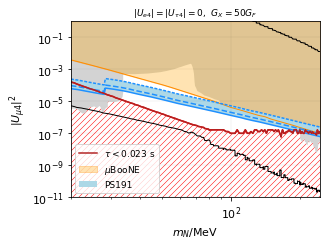

In [64]:
# grid of mix vs mass
gridx = 100
gridy = 100

M4 = np.linspace(0.02,(m_neutral_kaon - m_charged_pion - m_mu), gridx)
USQR = np.logspace(-11,0, gridy) 
X,Y = np.meshgrid(M4,USQR)
m4_grid, usqr_grid = X.flatten(), Y.flatten()



######
fig, ax = std_fig()

# HNL mass span
x = np.logspace(np.log10(20),np.log10((m_neutral_kaon - m_charged_pion - m_mu)*1e3), 1000, endpoint=True)

###################################
# plot all existing constraints

list_of_bounds=umu4.get_individual_bounds(muon_bounds, m4min=0.01, m4max=0.2)
# _ = plot_bound(ax, list_of_bounds['SIN_87'], units=1e3)
_ = plot_bound(ax, list_of_bounds['PSI_87'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['PS191'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['KEK'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['NA62_21'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['PIENU_19_lowT'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['PIENU_19_highT'], units=1e3, lw=0.0)
_ = plot_bound(ax, list_of_bounds['deGouvea_lowmass'], units=1e3, lw=0.0)

this_file = 'digitized/muboone_kelly_machado/PS_eff_avg.dat'
m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
f = interpolate.interp1d(np.log10(m4), np.log10(Umu4sq), kind='linear', bounds_error=False, fill_value='extrapolate', assume_sorted=False)    

ratio_gamma_nuee = hnl_tools.get_gamma_nuee((0.1,1e-6), flavor_struct=[0.0,1.0,0.0], GX=GX)/hnl_tools.get_gamma_nuee((0.1,1e-6), flavor_struct=[0.0,1.0,0.0], GX=0)
ax.fill_between(x, 10**f(np.log10(x))/np.sqrt(ratio_gamma_nuee), np.ones(len(f(x))), fc='orange', ec='darkorange', alpha=0.3, label=r'$\mu$BooNE')
ax.plot(x, 10**f(np.log10(x))/np.sqrt(ratio_gamma_nuee), c='darkorange', ls='-', lw=1)

# this_file = 'digitized/muboone_kelly_machado/PS_eff_scalar.dat'
# m4, Umu4sq = np.genfromtxt(this_file, unpack=True)
# f = interpolate.interp1d(m4, Umu4sq, kind='linear', bounds_error=False, fill_value=None, assume_sorted=False)    
# ax.plot(x, f(x), c='grey', ls='--', label='Kelly \& Machado 2')


############################################
# PS191 rescaled
N_observed = 30 # before handscan
no_bkg, all_bkg = get_PS191_limit(x*1e-3, nevent_for_new_limit = np.sqrt(N_observed))
_, all_sig = get_PS191_limit(x*1e-3, nevent_for_new_limit = N_observed+np.sqrt(N_observed))

no_bkg /= np.sqrt(ratio_gamma_nuee)
all_bkg /= np.sqrt(ratio_gamma_nuee)
all_sig /= np.sqrt(ratio_gamma_nuee)

ax.fill_between(x, no_bkg, all_bkg, facecolor='lightblue', lw=0.0, label=r'PS191')
ax.fill_between(x, all_bkg, all_sig, facecolor='lightblue', lw=0.0)
ax.plot(x, no_bkg, color='dodgerblue', ls='-')
ax.plot(x, all_bkg, color='dodgerblue', ls='--')
ax.plot(x, all_sig, color='dodgerblue', dashes=(2,1))


############################################
# our T2K bound -- Weak Interaction only
Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid*1e3, y=usqr_grid , z=np.array(event_rate_darknus), logx=False, logy=True)
level_0 = contour(Xi, Yi, Zi, levels = [2.3], colors=['black'], linewidths=[1]) #NEW CONSTRAINT
# bound = level_0.collections[0].get_paths()[0].vertices  #grab the coords of the bound
# ax.plot(bound[:,0],bound[:,1], c='black', label=r'T2K $\nu e^+e^-$', lw=1.5)


############################################
# BBN -- tau = 0.023 s
# BBN -- tau = 0.023 s
matplotlib.rcParams['hatch.color'] = 'red'  # previous pdf hatch linewidth
matplotlib.rcParams['hatch.linewidth'] = 0.5  # previous pdf hatch linewidth

Xi,Yi,Zi=plot_style.interp_grid(x=m4_grid*1e3, y=usqr_grid , z=lifetime_darknus, logx=False, logy=True)
level_1 = contour(Xi, Yi, Zi, levels = [0.023], colors=['red'], linestyles=['-']) #NEW CONSTRAINT
_ = contourf(Xi, Yi, Zi, levels = [0.023,np.inf], colors=['white'], alpha=1, hatches=['////'], linestyles=['-'], zorder=-1) #NEW CONSTRAINT
bound = level_1.collections[0].get_paths()[0].vertices  #grab the coords of the bound
ax.plot(bound[:,0],bound[:,1], c='firebrick', label=r'$\tau < 0.023$ s', lw=1.5)

# test against boyarki's
# mbound,ubound = np.genfromtxt('digitized/Boyarsky_et_al/BBN_Umu4_lower_bound.dat',unpack=True)
# plt.plot(mbound*1e3,ubound, c='green',lw=1)

# T2K bound
# ax.plot(masses_t2k, bayesian_upper_limit(n_events_T2K(eff, flux, 
#                                                           channels=np.arange(10), 
#                                                           modes=modes_dirac, 
#                                                           mode_weights=weights_modes_dirac)),
#             label=r'T2K', c='purple')


####
# labels
ax.set_title(r"$|U_{e4}| = |U_{\tau 4}| = 0$,  $G_X = 50 G_F$",fontsize=9)
ax.legend(loc='lower left', frameon=True, ncol=1, fontsize=9)

ax.set_xlim(np.min(x),np.max(x))
ax.set_ylim(1e-11,1e-0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$|U_{\mu 4}|^2$")
ax.set_xlabel(r"$m_{N}$/MeV")
# ax.set_yticks([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,1e-2])
# ax.set_xticks(np.array([0.02, 0.04, 0.06, 0.08, 0.1, m_neutral_pion-m_mu, m_neutral_kaon-m_mu-m_neutral_pion])*1e3)
# ax.set_xticklabels(np.array([0.02, 0.04, 0.06, 0.08, 0.1, r'$m_\pi-m_\mu$', r'$m_K - (m_\mu+m_\pi)$']), rotation = -30)
ax.grid(axis='y', which='both',dashes=(6,1),alpha=0.5,c='black',lw=0.1)
ax.grid(axis='x', which='major',dashes=(6,1),alpha=0.5,c='black',lw=0.1)
fig.savefig('plots/dark_decays.pdf')
fig.savefig('plots/dark_decays.png', dpi=400)

In [66]:
1/np.sqrt(gL**2 + gR**2 + gR*gL)

3.929588430674492